(sec:pdf_estimation)=
# Estimation of PDF and CDF distributions  

Continue from here updating this notebook. 


In [1]:
# import pre-installed packages and init. 
import numpy as np
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sys 
from myst_nb import glue

# add tools path and import our own tools
sys.path.insert(0, '../tools')
%load_ext autoreload
%autoreload 2
mpl.rcParams.update({'font.size': 14})

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

We will consider the illustrative example introduced in Section {ref}`sec:introduction_to_bayesian_inference`, please check that section for details. In short, the illustrative example consist on measuring a quantity X and predicting a label Y; in this toy example, X represent a feature we measure, and Y a binary variable associated to the diagnosis of ASD. 

In [2]:
# Let us create some toy data:
from create_data import create_headturn_toy_example
X_u, Y_u = create_headturn_toy_example(num_points=1e5, prop_positive=0.05)
X, Y = create_headturn_toy_example(num_points=1e3, prop_positive=0.2)

In Section {ref}`sec:introduction_to_bayesian_inference`, we discussed how to use the marginal probabilities $P(X|Y)$ to assess the diagnosis power of a feature "X" and, in particular, how to correctly measure performance in the context of imbalanced classes. During that discussion, we assumed $P(X|Y)$ was known, or more precisely, we assumed that a histogram of empirical observations was a _good approximation_ of the probability density function (PDF). This might or not be true; we need to analyze when a histogram is a good approximation of a PDF, and provide a formal numerical assessment for "_good approximation_." 

In the present section, we address most of the problems stated above. We provide quantitative indications of when a histogram is a good approximation of a PDF, and we show how to compute the optimal number of bins (or histogram resolution). We show how to calculate confidence intervals associated with empirical histograms. Also, we discuss the "Bootstrap" method, which is arguably one of the most robust and versatile techniques to estimate confidence intervals. Finally, we discuss the problem of estimating the parameters of a distribution.

(sec:cdf_definition)=
## CDF Definition

Let $X_1,...,X_n \sim F$ be an IID sample with distribution $F$. IID states for "independent identically distributed," i.e., all the samples are independent realizations of the same phenomenon. For example, consider the illustrative case introduced in Section {ref}`sec:introduction_to_bayesian_inference`. We measure for $n$ children in the ASD group their head-turn delay after a name call. All these events will be independent of each other, and all can be seen as a realization of a distribution $F$. The CDF $F(x)$ is formally defined as $P(X\leq x)$, in this example, the probability that child responds with a delay less than or equal to $x$. $F$ is unknown in practice, but in this toy example, we are simulating it. Since we have two different groups, we have two distributions $F_{ASD}$ and $F_{non-ASD}$. In this section, we are not focusing on distinguishing them but rather on how well we can approximate each. Hence, for the rest of the section, let us focus on a single one, for example, $F\stackrel{def}{=}F_{ASD}$. 

The **empirical distribution function** $\hat{F}$ is defined as:

$$
\hat{F}(x) = \frac{1}{n} \sum_{i=1}^{n} I(X_i \leq x)
$$ (eq:CDF_definition)

where $I(X_i \leq x) = 1$ if $X_i\leq x$, $0$ otherwise.

For example, {numref}`fig:CDF_empirical_approximation` shows for our toy example, the ground truth, and the empirical CDF estimated for 10, 20, and 200 observed samples.

In [3]:
# Let us create some toy data:
from create_data import create_headturn_toy_example
X_u, Y_u = create_headturn_toy_example(num_points=1e5, prop_positive=0.05)
X, Y = create_headturn_toy_example(num_points=1e3, prop_positive=0.2)

from stats import feature_values_positive_to_negative_ratio
Xp = X[Y==1]; Xn = X[Y==0]
df = pd.DataFrame({'X':X_u,'Y':Y_u}); 


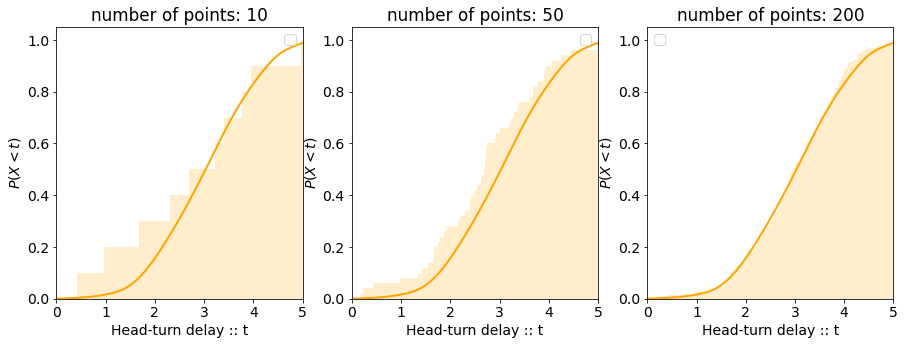

In [4]:
fig = plt.figure(figsize=[15,5])
# In addition plot the empirical distribution for different number of datapoints. 
num_bins = 200; xmin = 0; xmax=5; n = len(Xp)
h = (xmax-xmin)/ num_bins;  # bin size

ns = [10,50,200]
for (i,n) in enumerate(ns):
    plt.subplot(1,3,i+1)
    # Plot the ground truth comulative distribution (formally is an approximation with a lot of empirical points)
    sns.kdeplot(df.query('Y==1')['X'], cumulative=True, linewidth=2, color='orange');

    x = Xp[:n]  # Sample n points
    # Count empirical points per-bin 
    count, edges = np.histogram(x, range=[xmin, xmax], bins=num_bins)  
    # Convert count to an estimation of the prob(x in B)
    prob_bin = count/n
    # Convert from prob in interval to pdf (int(pdf)_B = proba_B)
    pdf = prob_bin/h  
    # Compute the comulative probability
    cdf = prob_bin.cumsum()
    plt.bar(edges[:-1]+h/2, cdf, width=h, color='orange', alpha=.2)
    plt.xlim([0,5]); plt.xlabel('Head-turn delay :: t'); plt.ylabel('$P(X<t)$')
    plt.legend([]); plt.title('number of points: {}'.format(n));
    
glue("CDF_empirical_approximation", fig, display=False)

```{glue:figure} CDF_empirical_approximation
:figwidth: 80%
:name: "fig:CDF_empirical_approximation"

Empirical approximation of the CDF, as we increase the number of samples. 
```

(sec:pdf_definition)=
## PDF definition
Similar to the CDF, the probability density distribution (PDF) is defined as:

$$
f(x) \stackrel{def}{=} \lim_{\delta\rightarrow 0} \frac{P(x\leq X < x+\delta)}{\delta} = \lim_{\delta\rightarrow 0} \frac{F(x+\delta)-F(x)}{\delta} = F'(x).
$$ (eq:pdf_definition)

We will skip all the mathematical technicalities and assume all the limits introduced above exist (i.e., the CDFs considered are differentiable everywhere). We will also consider in all the practical applications we are working with, the CDFs are "smooth." While $F(x)$ has a very intuitive meaning: "the probability that $X$ is lower than $x$," the interpretation of $f(x)$ is more difficult. $f(x)$ can be understood as the derivative of $F$, but was no probabilist meaning unless we integrate it in a interval, i.e., $P(x\in A) = \int_A p(x)\,dx$. 

```{admonition} Working with the PDF requiers additional hypothesis about regularity. 

As we will discuss, **estimating the error and confidence intervals associated with the approximation of $F$ is substantially simpler than $f$.** For example, look at the approximations shown in {numref}`fig:CDF_empirical_approximation`, $\hat{F}$ looks quite similar to $F$ (when we have a decent amount of data). However, $\hat{F} '(x)$ can be very different from $F'(x)$, and this is why working with $f$ is more challenging. As we will see, to approximate $f$, we will have to add the hypothesis that "F" is smooth. 

```

(sec:CDF_confidence_intervals)=
## CDF confidence intervals

As we discussed in Section {ref}`sec:cdf_definition`, estimating the CDF is quite straight forward. The **empirical distribution function** $\hat{F}$ is defined as:

$$
\hat{F}(x) = \frac{1}{n} \sum_{i=1}^{n} I(X_i \leq x)
$$ (eq:empirical_cdf)

where $I(X_i \leq x) = 1$ if $X_i\leq x$, $0$ otherwise.

It can be proved (Theorem 7.3 {cite}`wasserman2013all`) that at any fixed value of $x$,
- $\mathbf{E}(\hat{F}(x)) = F(x)$,
- $\displaystyle\mathbf{V}(\hat{F}(x)) = \frac{F(x)(1-F(x))}{n}$.  

These properties are general (no assumptions are made about $F$). Despite showing that the estimation makes sense (i.e., it will give as the right value as the number of samples increases), the previous expressions are of little practical advantage. The variance of $\hat{F}$, $V(\hat{F})$, could be used to compute confidence intervals; however, notice that to calculate it, we need $F$ (which is what we were trying to estimate in the first place). 

In order to compute confidence intervals associated to $\hat{F}$, we can exploit Dvoretzky-Kiefer-Wolfowitz inequality. Let $X_1, ..., X_n \sim F$, then for any $\epsilon>0$, 

$$
P\left(\sup_{x}|F(x)-\hat{F}(x)|>\epsilon\right)\leq 2e^{-2n\epsilon^2}.
$$ (eq:DKW_inequality)

From DKW inequality, we can construct a confidence interval for $\hat{F}$ as follows.

**Empirical CDF estimation confidence interval:**
Define $L(x) = \max\{\hat{F}-\epsilon,0\}$ and $U(x) = \min\{\hat{F}+\epsilon, 1\}$, where 

$$
\epsilon = \sqrt{\frac{1}{2n}\log\left(\frac{2}{\alpha}\right)}.
$$ (eq:conf_cdf)

It follows from DKW that (for any $F$), 

$$
P\left(L(x) \leq F(x) \leq U(x) \ \ \mbox{for all } x \right) \geq 1 - \alpha.
$$ (eq:conf_interval_cdf)


In [5]:
# This are the importan pieces of code:  (check "estimate_cdf" in stats.py)
alpha = 0.05  # Set for example, a 5% confidence interval
cdf_epsilon = lambda n, alpha: np.sqrt( (1/(2*n)) * np.log(2/alpha) )
U = lambda hatF, epsilon: min(hatF + epsilon, 1)
L = lambda hatF, epsilon: max(hatF - epsilon, 0)

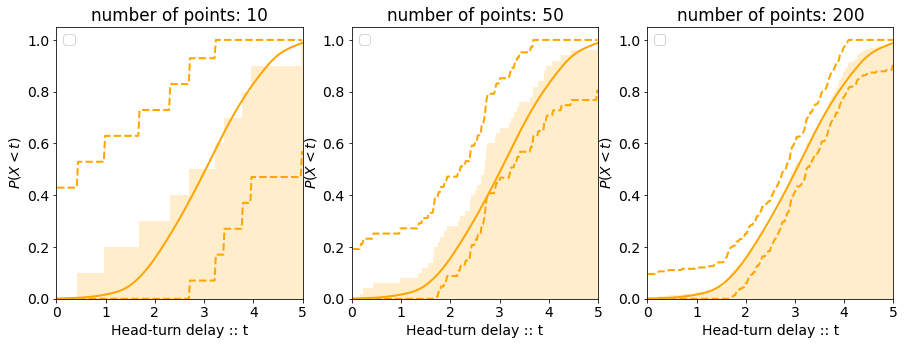

In [6]:
from stats import estimate_cdf
fig = plt.figure(figsize=[15,5])
# In addition plot the empirical distribution for different number of datapoints. 
num_bins = 200; xmin = 0; xmax=5; n = len(Xp)

ns = [10,50,200]
for (i,n) in enumerate(ns):
    plt.subplot(1,3,i+1)
    # Plot the ground truth comulative distribution (formally is an approximation with a lot of empirical points)
    sns.kdeplot(df.query('Y==1')['X'], cumulative=True, linewidth=2, color='orange');

    x = Xp[:n]  # Sample n points
    hatF, l, u = estimate_cdf(x, num_bins=num_bins, alpha=0.05, xmin=xmin, xmax=xmax, verbose=1)
    plt.xlim([0,5]); plt.xlabel('Head-turn delay :: t'); plt.ylabel('$P(X<t)$')
    plt.legend([]); plt.title('number of points: {}'.format(n));

glue("CDF_empirical_approximation_with_conf", fig, display=False)

```{glue:figure} CDF_empirical_approximation_with_conf
:figwidth: 80%
:name: "fig:CDF_empirical_approximation_with_conf"

Empirical approximation of the CDF and their associated 95% conf. inteval.  
```

{numref}`fig:CDF_empirical_approximation_with_conf` shows the estimation $\hat{F}$ of the distribution $F$, for datasets of different size. In addition the 95% confident interval associated to each of these estimations is illustrated. 

(sec: pdf_confidence_intervals)=
## PDF confidence intervals

We discussed that estimations of $F$ could be obtained without any explicit assumptions about $F$. On the other hand, estimating the density probability distribution $f$ requires some hypothesis about the regularity of the PDF. 

The simplest density estimator is a histogram. As before, let $X_1, ..., X_n$ be IID with density $f$ ($f=F'$), let assume the $X_i$ is restricted to the interval $[x_{min}, x_{max}]$, and let partition this interval into $m$ bins. The bin size $h$ can be computed as $h= (x_{max}-x_{min})/m$, the more bins (larger $m$) the smaller the bins size and vice-versa. 

{numref}`fig:pdf_examples` illustrates the histograms computed from $50$ empirical ASD samples of our toy head-turn delay example. We show the resulting histograms for three numbers of bins. Also (solid line), the ground truth PDF is plotted. 

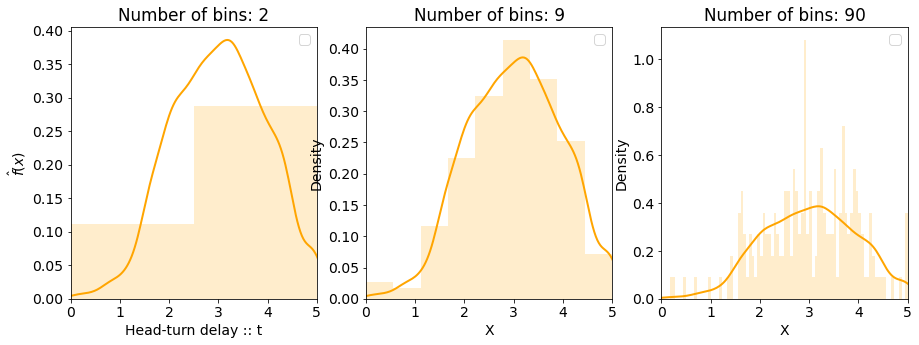

In [7]:
# Impact of the bin size on the estimation error. 
fig = plt.figure(figsize=[15,5])
# In addition plot the empirical distribution for different number of datapoints. 
xmin = 0; xmax=5; n = 200
x = Xp[:n]  # Sample n points

num_bins_set = [2,9,90]
for (i,num_bins) in enumerate(num_bins_set):
    h = (xmax-xmin)/ num_bins;  # bin size

    plt.subplot(1,3,i+1)
    # Plot the ground truth comulative distribution (formally is an approximation with a lot of empirical points)
    sns.kdeplot(df.query('Y==1')['X'], cumulative=False, linewidth=2, color='orange');

    # Count empirical points per-bin 
    count, edges = np.histogram(x, range=[xmin, xmax], bins=num_bins)  
    # Convert count to an estimation of the prob(x in B)
    prob_bin = count/n
    # Convert from prob in interval to pdf (int(pdf)_B = proba_B)
    pdf = prob_bin/h  
    
    plt.bar(edges[:-1]+h/2, pdf, width=h, color='orange', alpha=.2)    
    if i == 0:
        plt.xlabel('Head-turn delay :: t'); plt.ylabel('$\hat{f}(x)$');
    plt.legend([]); plt.title('Number of bins: {}'.format(num_bins)); plt.xlim([0,5]);

glue("pdf_examples", fig, display=False)

```{glue:figure} pdf_examples
:figwidth: 80%
:name: "fig:pdf_examples"

Approximating the pdf with a discrete histogram. We illustrate the impact of the number of bins on the pdf estimation. 
```

To estimate $\hat{f}$, we first define the set of bins $\mathcal{B} = \{B_1, ..., B_m\}$. In our toy example, the bins are simply the intervals $B_i = (x_{min} + h(i-1), x_{min} + hi]$. The probability of $X$ to be in $B_i$ can be estimated as 

$$
\hat{p}_i = \frac{1}{n} \sum_{i=1}^n I(X_i \in B_i),
$$ 

and the pdf estimator $\hat{f}$ by

$$
\hat{f}(x) = \left\{\begin{array}{l}
\hat{p}_1/h  \ \ x\in B_1 \\ 
\hat{p}_2/h  \ \ x\in B_2 \\ 
... \\
\hat{p}_m/h  \ \ x\in B_m \\ 
\end{array}\right. .
$$ (eq:pdf_discrete_approximation)

Before discussing confidence intervals associated with these estimations, let us focus on the estimation error. As we can see, e.g., comparing the left and right examples in {numref}`fig:pdf_examples`, estimating $\hat{f}$ requires setting the bin size which has a great impact. A small number of bins (first example in {numref}`fig:pdf_examples`) would fail to accurately approximate $f$ do to the lack of spatial resolution. On the other extreme, (third example in {numref}`fig:pdf_examples`), too many bins would produce quantities prone to error (since only a few points lie in each segment). 

The problem discussed above can be formalized as follows. The integrated squared error (ISE) for the estimation $\hat{f}$ can be defined as:

$$
L\left(f, \hat{f}\right) = \int \left( f(x)-\hat{f}(x) \right)^2 dx. 
$$ (eq:ISE_pdf)

The risk or mean integrated squared error (MISE) is, 

$$
R\left(f, \hat{f}\right) = \mathbf{E}\left(L\left(f, \hat{f}\right)\right).
$$ (eq:MISE_pdf)

**Lemma 2.1 ([1] pag. 304)** The risk can be written as

$$
R\left(f, \hat{f}\right) = \int{b^2(x) dx} + \int{v(x) dx}
$$ (eq:risk_tradeoff)

where $b(x) = \mathbf{E}\left(\hat{f}(x)-f(x)\right)$ is the bias of $\hat{f}$ (at $x$), and $v(x) = \mathbf{V}\left(\hat{f}(x)\right)$ is the variance of the estimated value at $x$, $\hat{f}(x)$. 

```{admonition} Risk trade-off
:class: tip
**RISK = BIAS$^2$ + VARIANCE**
```

If the bins width is too large, a large bias cause large errors, on the other hand, if the bins are too narrow, the variance of the estimator will be large leading also to a poor approximation. **The optimal bin width is set by balancing these two factors such that the risk is minimized.** 

### Setting the optimal number of histograms

Setting the optimal number of bins $m^*$ by minimizing the risk function defined above is impractical, since it computation requires the knowledge of the ground truth density $f$ (a chicken and egg problem). Instead, we can solve an approximation of the error loss function as defined below.  

$$
L(f,\hat{f}) = \int\left(\hat{f}(x)-f(x)\right)^2 dx = \int \hat{f}^2(x) dx - 2\int \hat{f}(x)f(x) dx + \int f^2(x) dx, 
$$ (eq:loss_approximation)

the last term doesn't depend on $m$ so minimizing the risk is equivalent to minimizing the expected value of 

$$
J(f, \hat{f}) = \int \hat{f}^2(x) dx - 2\int \hat{f}(x)f(x) dx.
$$

We shall refer now to $\mathbf{E}(J)$ as the risk (thought formally it differs from it by a constant factor). The cross-validation estimator for the risk is 

$$
\hat{J}(\hat{f}) = \int \left( \hat{f}(x) \right)^2 dx - \frac 2 n \sum_{i=1}^{n} \hat{f}_{(-i)}(X_i)
$$

where $\hat{f}_{(-i)}$ is the histogram estimator obtained after removing the $i^{th}$ observation. 

```{admonition} Theorem 2.1 

The following identity holds ({cite}`wasserman2013all` pag. 310):

$$
\hat{J}(\hat{f}) = \frac{2}{(n-1)h} - \frac{n+1}{(n-1)h}\sum_{i=1}^{m} \hat{p}_i^2. 
$$ (eq:risk_estimation)

```

Equation {eq}`eq:risk_estimation` provides a practical alternative to compute the error associated with a bin size, and can be used to tune it as we illustrate below ({numref}`fig:pdf_empirical_risk_estimation`). 


```{caution}
In {cite}`wasserman2013all` the definition is incorrect in Eq. (20.14). $h$ is missing in the second term, see the original reference (Mats Rudemo 1981, Empirical Choice of Histograms and Kernel Denisty Estimators; Eq. (2.8)).
```

In [28]:
# To optimize the number of bins, we can use this expresion: (check bin_size_risk_estimator for more details).
def hat_J(hat_p, n): 
    """
    Compute the cross-validation estimator of the risk. 
    hat_p: is N_i/n, where N_i is the number of datapoints in the ith bin
    n: is the number of datapoints
    """
    m = len(hat_p)  # the number of p_i is the number of bins. 
    h = 1/m  # When theorem 2.1 is obtained, the data is assumed to be mapped to the range [0,1]
    # therefore, when m bins are selected, the bin width is h=1/m
    J = 2 / ((n-1)*h) - (n+1) / (n-1) / h  * np.sum(np.square(hat_p))
    return J

           Figure 2.4: Risk approximation and optimal number of bins


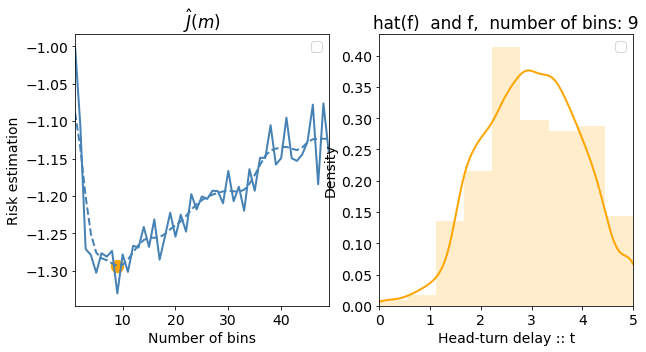

In [38]:
fig = plt.figure(figsize=[10,5])

xmin = 0; xmax=5; n = 200
x = Xp[:n]  # Sample n points

from stats import bin_size_risk_estimator
plt.subplot(1,2,1)
hat_J, opt_num_bins = bin_size_risk_estimator(x, num_bins_range=[1,50], xmin=xmin, xmax=xmax, verbose=1)

plt.subplot(1,2,2)
sns.kdeplot(df.query('Y==1')['X'], cumulative=False, linewidth=2, color='orange');  # plot grount truth
num_bins = opt_num_bins; h = (xmax-xmin)/ num_bins;  # bin size
count, edges = np.histogram(x, range=[xmin, xmax], bins=num_bins)  
prob_bin = count/n; pdf = prob_bin/h; plt.bar(edges[:-1]+h/2, pdf, width=h, color='orange', alpha=.2)    
plt.xlim([0,5]); plt.xlabel('Head-turn delay :: t'); 
plt.legend([]); plt.title('hat(f) and f,  number of bins: {}'.format(num_bins));
glue("pdf_empirical_risk_estimation", fig, display=False)

```{glue:figure} pdf_empirical_risk_estimation
:figwidth: 80%
:name: "fig:pdf_empirical_risk_estimation"

The left side illustrates the ground truth risk (dashed) and the empirical risk estimation (solid) as we change the number of bins (i.e., the bin width). The right plot illustrates the ground truth pdf distribution and the histogram estimation for the optimal number of bins. 
```

### Confidence intervals associated to a pdf estimation

Once a histogram estimation of a pdf is obtained (after setting the number of bins and the bin size), we can estimate confidence intervals associated to it. Suppose $\hat{f}$ is a histogram with $m$ bins and binwidth $h=1/m$, approximating the ground truth density $f$. We define $\bar{f}=p_i/h$ where $p_i = \int_{B_i} f(x)dx$. As before, $B_i$ represents the interval associated to the $i^{th}$ bin. $\bar{f}$ represents the ground truth "histogram version" of the pdf $f$. 

```{admonition} Definition
A pair of functions $(l(x), u(x))$ is a $1-\alpha$ confidence band if, 

$$
\mathbf{P}\left( l(x) \leq \bar{f}(x) \leq u(x) \mbox{ for all } x \right) \geq 1-\alpha
$$ (eq:def_confidence_band)

```

```{admonition} Theorem

Theorem 2.2 {cite}`wasserman2013all` Pag. 311: Let $m(n)$ be the number of bins in the histogram $\hat{f}$. Assume $m(n)\rightarrow 0$ and $m(n)\frac{\log(n)}{n}\rightarrow 0$ as $n\rightarrow \infty$. Define 

$$
l(x) = \left(\max\left\{ \sqrt{\hat{f}(x)} -c, 0\right\} \right)^2
$$

$$
u(x) = \left(\sqrt{\hat{f}(x)} + c \right)^2
$$

where 

$$
c = \frac{z_{\alpha/(2m)}}{2}\sqrt{\frac{m}{n}}.
$$ (eq:c_pdf_interval)

Then, $(l(x),u(x))$ is an approximate $1-\alpha$ confidence band. 
```

In [41]:
# (see compute_histogram_and_conf_interval)
def compute_hist_conf_constant(alpha, m, n):   
    def z_u(u):  # Compute the upper u quantile of N(0,1)
        from scipy.stats import norm
        z = norm.ppf(1-u)  # z_u = Phi^-1(1-u)  with Phi = cdf_{N(0,1)}
        return z
    c = z_u(alpha/(2*m))/2 * np.sqrt(m/n)
    return c

lf = lambda hat_f,c: (max( np.sqrt(hat_f)-c, 0 ))**2
uf = lambda hat_f,c: (np.sqrt(hat_f)+c)**2

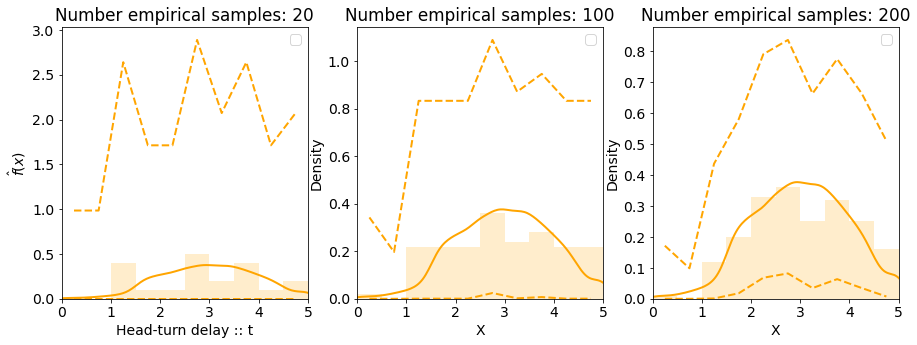

In [42]:
# Impact of the bin size on the estimation error. 
from stats import compute_histogram_and_conf_interval
fig = plt.figure(figsize=[15,5])
# In addition plot the empirical distribution for different number of datapoints. 
xmin = 0; xmax=5; num_bins = 10; alpha = 0.05 # Conf interval
 
ns = [20, 100, 200]
for (i,n) in enumerate(ns):
    x = Xp[:n]  # Sample n points
    
    plt.subplot(1,3,i+1)
    sns.kdeplot(df.query('Y==1')['X'], cumulative=False, linewidth=2, color='orange');

    # Count empirical points per-bin 
    hat_f, l, u = compute_histogram_and_conf_interval(x, xmin=xmin, xmax=xmax, alpha=alpha, 
                                                      num_bins=num_bins, verbose=1)
    if i == 0:
        plt.xlabel('Head-turn delay :: t'); plt.ylabel('$\hat{f}(x)$');
    else:
        plt.xlabel(' ')
    plt.legend([]); plt.title('Number empirical samples: {}'.format(n)); plt.xlim([0,5]);
glue("pdf_histogram_confidence_intervals", fig, display=False)

```{glue:figure} pdf_histogram_confidence_intervals
:figwidth: 80%
:name: "fig:pdf_histogram_confidence_intervals"

Ground truth distribution (solid), and the estimated histograms with their associated 5-95% confidence intervals for different number of samples. 
```

{numref}`fig:pdf_histogram_confidence_intervals` shows the ground truth $f$, and the estimated $\hat{f}$ from 20, 100, and 200 empirical samples. (In all the cases we We used the optimal bin size estimated above.) The $5\%-95\%$ confidence interval associated with each estimation is displayed. 

As we can see, the intervals get narrower as the number of samples increases. Even for 200 samples, the uncertainty bounds estimated is quite large; tighter estimations can be obtained using kernel based methods which we will address next. 

### Kernel-based density estimation 

Kernel density estimators are smoother and converge faster to the true distributions, i.e., they are more accurate for the same amount of samples providing tighter confidence intervals. As above $X_1, ..., X_n$ are IID samples from $f$. Given a kernel $K$ and a positive number $h$ (called _the bandwidth_), the kernel density estimator is defined 

$$
\hat{f}(x) = \frac{1}{n} \sum_{i=1}^{n} \frac 1 h K\left(\frac{x-X_i}{h}\right).
$$ (eq:kernel_estimation)

To construct a kernel density estimator we need to choose a kernel $K$ and a bandwidth $h$. It can be shown that the selection of $h$ is important while the choice of $K$ isn't crucial {cite}`wasserman2013all`. Here, we will use the Gaussian kernel: 

$$
\displaystyle K(u) = \frac{1}{\sqrt{2\pi}} e^{\frac{-u^2}{2}}. 
$$ (eq:gaussian_kernel)

{numref}`fig:pdf_kernel` shows the kernel density estimator for the head-turn delay example introduced above. 

In [120]:
# Example of a kernel estimation implementation 
def kernel_estimator(X,x=None,h=1):
    K = lambda u: 1/np.sqrt(2*np.pi) * np.exp(-u**2 / 2)
    n = len(X)  # number of samples    
    hat_f = np.zeros_like(x)  # init.
    for j, x_j in enumerate(x):
        for X_i in X:
            hat_f[j] += 1/(n*h) * K( (x_j-X_i) / h )
    return hat_f

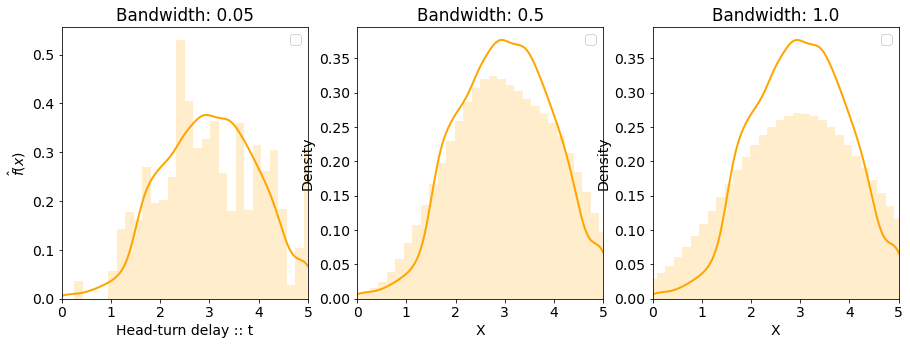

In [44]:
from stats import kernel_estimator
# Impact of the bin size on the estimation error. 
fig = plt.figure(figsize=[15,5])
# In addition plot the empirical distribution for different number of datapoints. 
xmin = 0; xmax=5; n = 200; X = Xp[:n] 
h0 = (xmax-xmin)/10  # Bandwidth
N = 30  # x resolution for the estimation of the kernel. 
x = np.linspace(xmin,xmax,N)  # Define the points in which the density is estimated. 

h_set = [h0/10,h0,2*h0]  # Define the set of bandwidths.
for (i,h) in enumerate(h_set):
    plt.subplot(1,3,i+1)
    # Plot the ground truth comulative distribution (formally is an approximation with a lot of empirical points)
    sns.kdeplot(df.query('Y==1')['X'], cumulative=False, linewidth=2, color='orange');
    # Count empirical points per-bin 
    hat_f = kernel_estimator(X,x=x,h=h)
    plt.bar(x, hat_f, width=x[1]-x[0], color='orange', alpha=.2)    
    if i == 0:
        plt.xlabel('Head-turn delay :: t'); plt.ylabel('$\hat{f}(x)$');
    plt.legend([]); plt.title('Bandwidth: {}'.format(h)); plt.xlim([0,5]);
glue("pdf_kernel", fig, display=False)

```{glue:figure} pdf_kernel
:figwidth: 80%
:name: "fig:pdf_kernel"

Kernel estimation for 200 samples, for different bandwidth sizes. 
```

As we illustrate in {numref}`fig:pdf_kernel`, the bandwidth $h$ plays a similar role to the number of bins in the histogram estimation. The smaller the bandwidth, the larger the error because of variance, the larger the bandwidth, the larger the error because of bias. As for the number of bins, we need to estimate the optimal bandwidth by minimizing the approximation error. Recall that:

> RISK = BIAS^2 + VARIANCE


The cross-validation estimation of the risk $\hat{J}(h)$ can be approximated using Theorem 2.3.

```{admonition} Theorem
Theorem 2.3 {cite}`wasserman2013all` Pag. 316: For any $h>0$, $\mathbf{E}[\hat{J}(h)] = \mathbf{E}[J(h)]$, and 

$$
\hat{J}(h) \approx \frac{1}{h n^2}\sum_{i}\sum_{j} K^*\left(\frac{X_i-X_j}{h}\right) + \frac{2}{nh}K(0)
$$

where $K^*(u) = K^{(2)}(u)-2 K(u)$ and $K^{(2)}(z) = \int K(z-y)K(y)dy$. In particular, if $K$ is $N(0,1)$, then $K^{(2)}$ is the $N(0,2)$ density. 
```

{numref}`fig:pdf_kernel_estimation_optimal_bandwidth` shows the estimated risk (left) and the estimated density for the optimal bandwidth. 

In [46]:
def kernel_based_empirical_risk(X, h):
    # Define shortcuts for K K2 and K_ast
    K = lambda u: 1/np.sqrt(2*np.pi) * np.exp(-u**2 / 2)  # Define the kernel N(0,1)
    K2 = lambda u: 1/np.sqrt(2*np.pi * 2) * np.exp(-u**2 / (2 * 2))  # Define the kernel with sigma^2=2
    K_ast = lambda u: K2(u) - 2*K(u)    
    n = len(X)
    J = 2/(n*h) * K(0)  #  Left term [1] pag. 316, Eq (20.25)
    for X_i in X:
        for X_j in X:
            J += 1 / (h * n**2) * K_ast( (X_i-X_j) / h )
    return J

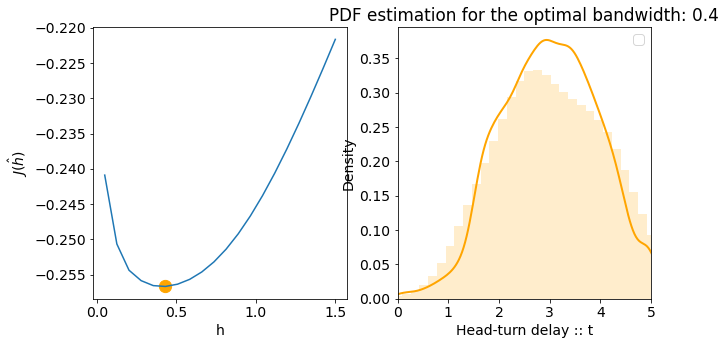

In [48]:
from stats import kernel_estimator
# Impact of the bin size on the estimation error. 
fig = plt.figure(figsize=[10,5])
# In addition plot the empirical distribution for different number of datapoints. 
xmin = 0; xmax=5; n = 200; X = Xp[:n] ; N = 30  # x resolution for the estimation of the kernel. 
x = np.linspace(xmin,xmax,N)  # Define the points in which the density is estimated. 

from stats import kernel_based_empirical_risk
hs = np.linspace(0.05,1.5,20)
J = [kernel_based_empirical_risk(X,hh) for hh in hs]
plt.subplot(1,2,1); plt.plot(hs,J); plt.xlabel('h'); plt.ylabel('$\hat{J(h)}$')
h_opt = hs[np.argmin(J)]  # get opt bandwidth
plt.scatter(h_opt, min(J), 150, color='orange')
plt.subplot(1,2,2); sns.kdeplot(df.query('Y==1')['X'], cumulative=False, linewidth=2, color='orange');
hat_f = kernel_estimator(X,x=x,h=h_opt)
plt.bar(x, hat_f, width=x[1]-x[0], color='orange', alpha=.2)    
plt.xlabel('Head-turn delay :: t'); plt.xlim([0,5]);
plt.legend([]); plt.title('PDF estimation for the optimal bandwidth: {:2.1f}'.format(h_opt)); 
glue("pdf_kernel_estimation_optimal_bandwidth", fig, display=False)

```{glue:figure} pdf_kernel_estimation_optimal_bandwidth
:figwidth: 80%
:name: "fig:pdf_kernel_estimation_optimal_bandwidth"

Kernel bandwidth optimization (left), and the kernel estimation for the optimal bandwidth)
```

### Confidence associated with a kernel estimation

As for the estimated histograms, confidence intervals can be computed for the kernel density estimation. The confidence band is defined for a smoothed version $\bar{f}$ of the ground truth distribution $f$, defined as

$$
\bar{f}(x)=\int{\frac 1 h K \left( \frac{x-u}{h} \right) f(u)\, du } \ = \mathbf{E}(\hat{f}(x).
$$ (eq:bar_f_conf_interval)

When the normal kernel is used, a $1-\alpha$ confidence interval $(l(x),u(x))$ is given by

$$
l(x) = \hat{f}(x)- q\, \mbox{se}(x), u(x) = \hat{f}(x) + q\, \mbox{se}(x)
$$

where 

$$
\mbox{se}(x) = \frac{s(x)}{\sqrt{n}}, \ \ s^2(x) = \frac{1}{n-1} \sum_i (Y_i(x) - \bar{Y}(x))^2, \ \ \left(\bar{Y}(x) = \frac 1 n \sum_i Y_i(x)\right),\ Y_i(x) = \frac{1}{h} K\left(\frac{x-X_i}{h}\right),
$$

$$
q = \Phi^{-1}\left(\frac{1 + (1-\alpha)^{1/m}}{2}\right), \mbox{ and } m=3h.
$$

{numref}`fig:kernel_estimation_with_CI` illustrates the $95\%$ confidence intervals for the kernel density estimation presented in {numref}`fig:pdf_kernel_estimation_optimal_bandwidth`. Compare this result with the ones obtained for the histogram estimator {numref}`fig:pdf_histogram_confidence_intervals`. 

In [164]:
# Example of implementation (see stats compute_kernel_estimator_and_conf_intervals for more details).
def compute_kernel_estimation_conf(X, hat_f=None, x=None, h=None, alpha=0.05):
    K = lambda u: 1/np.sqrt(2*np.pi) * np.exp(-u**2 / 2)  # Define the kernel N(0,1)
    from scipy.stats import norm
    m = 3*h
    q = norm.ppf( ( 1 + (1-alpha)**(1/m) ) / (2) )  # ppf(x) = Phi^-1(x)  Phi = cdf_{N(0,1)}
    n = len(X)
    l = np.zeros_like(hat_f); u = np.zeros_like(hat_f)  # init.
    for j,xx in enumerate(x):  # for each x coordinate compute l(x) and u(x)
        Y_i = np.array([ 1/h * K((xx-XX)/h) for XX in X]) 
        bar_Y = np.mean(Y_i)
        s_square = 1 / (n-1) * np.sum( (Y_i-bar_Y)**2 )
        se = np.sqrt(s_square) / np.sqrt(n)
        l[j] = hat_f[j] - q*se
        u[j] = hat_f[j] + q*se
    return l, u

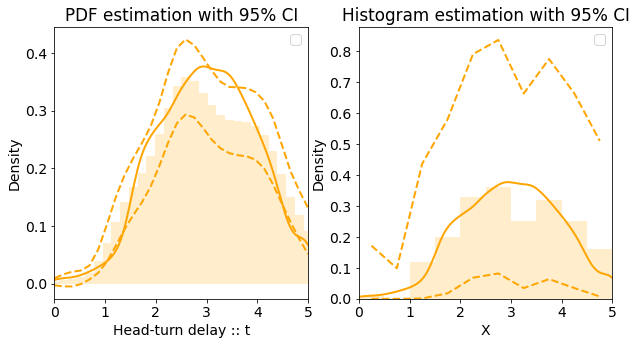

In [49]:
from stats import kernel_estimator
# Impact of the bin size on the estimation error. 
fig = plt.figure(figsize=[10,5])
# In addition plot the empirical distribution for different number of datapoints. 
xmin = 0; xmax=5; n = 200; X = Xp[:n] ; N = 30  # x resolution for the estimation of the kernel. 
x = np.linspace(xmin,xmax,N)  # Define the points in which the density is estimated. 
alpha=0.05  # set conf. interval

from stats import compute_kernel_estimator_and_conf_interval
h = 0.3; 
plt.subplot(1,2,1); sns.kdeplot(df.query('Y==1')['X'], cumulative=False, linewidth=2, color='orange');
hat_f, l, u = compute_kernel_estimator_and_conf_interval(X,x=x,xmin=xmin,xmax=xmax,h=h,
                                                         alpha=alpha,verbose=1)
plt.xlabel('Head-turn delay :: t'); plt.xlim([0,5]); plt.legend([]); 
plt.subplot(1,2,2);  
sns.kdeplot(df.query('Y==1')['X'], cumulative=False, linewidth=2, color='orange');
hat_f, l, u = compute_histogram_and_conf_interval(X, xmin=xmin, xmax=xmax, alpha=alpha, 
                                                  num_bins=num_bins, verbose=1)
plt.title('Histogram estimation with 95% CI'); plt.legend([]); 
glue("kernel_estimation_with_CI", fig, display=False)

```{glue:figure} kernel_estimation_with_CI
:figwidth: 80%
:name: "fig:kernel_estimation_with_CI"

Kernel PDF estimation and its 95% CI (left), and the Histogram PDF estimation with its associated CI (right). In both cases the optima bandwidth/bin size was selected. 200 empirical samples were considered for both. 
```

As discussed above, kernel estimations provide tighter approximations for the same amount of data, and have, in general, a faster convergence to the ground truth distribution. 

(sec:parameter_estimation)= 
## Parameter estimation

In the previous sections, we focused on the estimation of distributions on a model agnostic fashion. Meaning, no hypothesis about the nature of the distribution was made. In contrast, if we know the distribution model, for example, that the distribution is Gaussian, we only need to estimate two number to characterize the process: the mean and standard deviation. In other scenarios, even if we don't know the model of the distribution, we might still only care about certain properties of the distribution, such as its mean. The approximation of these quantities is described as the theory of parameter estimation. 

```{admonition} Theorem
Theorem 2.4: The Central Limit Theorem (CLT)** Let $X_1, ..., X_n$ be IID with mean $\mu$ and variance $\sigma^2$. Let $\bar{X}_n = n^{-1} \sum_{i=1}^n X_i$. Then

$$
\frac{\bar{X}_n-\mu}{\sigma / \sqrt{n}} \stackrel{n\rightarrow \infty}{\rightsquigarrow} N\left(0, 1\right).
$$
```

In Theorem 2.4 $X_n \rightsquigarrow F$ means that $X_n$ converges to $F$ _in distribution_, i.e., $\lim_{n\rightarrow \infty} F_n(x) = F(x)$ for all $x$ for which $F$ is continuous. (A formal and more exhaustive explanation is provided in {cite}`wasserman2013all` {cite}`kay1993fundamentals`). This theorem is central to the objectives of this section. First, it tells us that a simple average of the samples is a good approximation of the mean of the distribution of $X_i$. As the number of samples increases, it tells us that the error tends to 0. It also gives an idea of the error (the variance) which, as we shall see, can be used to estimate confidence intervals. The most remarkable part is that it tells us that $\bar{X_n}$ has a normal probability distribution, with no hypothesis about $F$! (the distribution of $X_i$). 

```{admonition} Theorem
Theorem 2.5 ({cite}`wasserman2013all` pag. 78) Assume the same conditions as in Theorem 2.4. And define, 

$$
S_n^2 = \frac{1}{n-1} \sum_{i=1}^{n}(X_i - \bar{X}_n)^2.
$$

Then, 

$$
\frac{\bar{X}_n-\mu}{S_n / \sqrt{n}} \stackrel{n\rightarrow \infty}{\rightsquigarrow} N\left(0, 1\right).
$$
```

Theorem 2.5 essentially tell us that we can still apply the CLT using the estimated variance $S_n$ instead of the ground truth variance $\sigma$. This is very useful since $\sigma$ is unknown in practice. Using Theorem 2.5, computing a $\alpha$ confidence interval for $\bar{X}_n$ is straightforward: $\bar{X}_n \pm z_{\alpha/2} \frac{S_n}{\sqrt{n}}$. (For $\alpha=0.05$, $z_{\alpha/2} = 1.96 \approx 2$, is common then to use the approximated rule of $\pm 2 \frac{S_n}{\sqrt{n}}$.) Below we provide computations examples for the toy data used across this section. 

In [50]:
# As before, for compactness we refer to the positive class the class of ASD kids, 
# and negative class the clas of non-ASD kids. 
num_p = len(Xp); num_n = len(Xn)  # number of samples in each group

bar_Xp = np.mean(Xp); bar_Xn = np.mean(Xn);  # Empirical mean of each sample

# Shortcut for the emp. estimation of the std (numpy uses 1/n instead 1/n-1)
var = lambda X: 1/(len(X)-1) * np.sum(np.array( [(X_i-np.mean(X))**2 for X_i in X] ))


Sp = np.sqrt(var(Xp)); Sn = np.sqrt(var(Xn));  # Empirical estimation of the square root of the variance S
# Compute the 5% conf. interval (we use the approx z_(5%/2) ~ 2)
conf_p = 2*Sp/np.sqrt(num_p); conf_n = 2*Sn/np.sqrt(num_n)

print('The estimated mean for the head-tourn delay (mean and 95% CI).')
print('ASD group     :: {:2.2f} +- {:2.2f} seconds'.format(bar_Xp, conf_p))
print('non-ASD group :: {:2.2f} +- {:2.2f} seconds'.format(bar_Xn, conf_n))

The estimated mean for the head-tourn delay (mean and 95% CI).
ASD group     :: 3.04 +- 0.14 seconds
non-ASD group :: 1.43 +- 0.08 seconds


What if we want to model the difference between the two means? We can use that the difference between to (independent) normally distributed variables is also normal. If $X_1\,\sim\,N(\mu_1,\sigma_1^2)$, $X_2\,\sim\,N(\mu_2,\sigma_2^2)$, then $Y = X_1-X_2\, \sim\, N(\mu_1-\mu_2,\sigma_1^2+\sigma_2^2)$.

In [51]:
mean_diff = bar_Xp - bar_Xn
S_diff = np.sqrt( (Sp/np.sqrt(num_p))**2 + (Sn/np.sqrt(num_n))**2 )
conf_diff = 2*S_diff
print('The ASD kids respond in average {:2.2f} +- {:2.2f} seconds slower than the non-ASD kids.'.format(mean_diff, conf_diff))

The ASD kids respond in average 1.61 +- 0.16 seconds slower than the non-ASD kids.


### A general framework

The ideas discussed in Sections {ref}`sec:cdf_definition`, {ref}`sec:pdf_definition` and {ref}`sec:parameter_estimation` can be unified in a more general framework. Let $X_1, ..., X_n$ be IID samples from some distribution $F$. $\theta$ denotes a parameter we want to estimate, e.g., the ground truth height of the histogram for some bin $B_i$, or the mean of $F$ $\mu$. $\hat{\theta}$ denotes our estimation of $\theta$ from the observed data. $\hat{\theta}$ can be expressed as a function of the random variables $X_i$: $\hat{\theta}=g(X_1, ..., X_n)$. As this is a function of random variables, $\hat{\theta}$ is itself a random variable. 

For example, on the experiment discussed above, $\theta=\mu$, and we defined our estimator $\hat{\theta}=\bar{X_n}$. The CLT tells us that the distribution of the random variable $\hat{\theta}$ is normal (regardless of what is the distribution $F$ that generated the samples $X_i$). 

The bias of an estimator is defined by,

$$
\mbox{bias}(\hat{\theta}) = \mathbf{E}(\hat{\theta})-\theta,
$$

and the standard error $\mbox{se} = \sqrt{\mathcal{V}(\hat{\theta})}$.

The mean squared error is defined as 

$$ 
MSE = \mathbf{E}(\hat{\theta}-\theta)^2.
$$

```{admonition} Theorem
Theorem 2.6 ({cite}`wasserman2013all` pag. 91) The MSE can be written as

$$
MSE = \mbox{bias}^2(\hat{\theta}) + \mathbf{V}(\hat{\theta}).
$$

```

```{admonition} Definition
An estimator is asymptotically normal if 

$$
\frac{\hat{\theta}-\theta}{\mbox{se}} \stackrel{n\rightarrow \infty}{\rightsquigarrow} N\left(0, 1\right).
$$

```

For example, in the experiment illustrated above, we estimated the mean by the empirical mean, we had an asymptotically normal estimator with $\mbox{se}=\sigma/\sqrt{n}$. Obtaining confidence intervals for asymptotically normal estimators is straight forward, an $\alpha$ confidence interval is $\hat{\theta}\pm z_{\alpha/2}\mbox{se}$. (Remember that for $\alpha=5\%$, $z_{\alpha/2}=1.96 \approx 2$.  

### Bootstrap method

The bootstrap is a method for estimating standard errors and computing confidence intervals. Let $X_1, ..., X_n\sim F$ be a set of random variables and $\hat{\theta} = g(X_1,...,X_n)$ any function of the data. The goal is to estimate the variance $\mathbf{V}_F(\hat{\theta})$. We write $\mathbf{V}_F(\hat{\theta})$ to emphasize that the variance usually depends on the unknown distribution $F$. Bootstrap has two main step: (i) estimate $\mathbf{V}_F(\hat{\theta})$ with $\mathbf{V}_{\hat{F}}(\hat{\theta})$, and (ii) approximate $\mathbf{V}_{\hat{F}}(\hat{\theta})$.

#### Estimating the variance 

The first step consists of estimating the variance of $\hat{\theta}$ assuming $F=\hat{F}$ where $\hat{F}$ is the empirical distribution of the data. Since $\hat{F}$ puts $1/n$ probability in each sample, simulating new samples $X^*_1, ..., X^*_n\sim \hat{F}$ is equivalent of sampling with replacement $n$ samples from $\{X_1, ..., X_n\}$. The method can be summarized as follows. 
1. Draw $X_1^*, ..., X_n^*\sim \hat{F}$.
2. Compute $\hat{\theta}^* = g(X_1^*, ..., X_n^*)$.
3. Repeat steps 1 and 2, $B$ times, to get $\hat{\theta}^*_1, ..., \hat{\theta}^*_B$.
4. Let 

$$
v_{boot} = \frac 1 B \sum_{b = 1}^{B} \left( \hat{\theta}^*_b - \bar{\theta}^* \right)^2,
$$

where $\bar{\theta}^* = \frac 1 B \sum_b \hat{\theta}^*_b$.


Remember we are doing two approximations:

$$
\mathbf{V}_F(\hat{\theta}) \stackrel{\mbox{not so small}}{\approx} \mathbf{V}_{\hat{F}}(\hat{\theta}) \stackrel{\mbox{small}}{\approx} v_{boot}. 
$$

#### Bootstrap confidence intervals

There are several methods to construct bootstrap confidence intervals. We discuss two: _The Normal Interval_, and _the pivotal interval_. 

```{admonition} Method 1: The normal interval.

This method is straight forward but has a limitation: it assumes the distribution of $\hat{\theta}$ is approximately normal (if we estimate the mean $\hat{X}$, for example, this is true thanks to the CLT). Then, the $1-\alpha$ confidence interval is simply $\hat{\theta} \pm z_{\alpha / 2}\sqrt{v_{boot}}$. 

```

```{admonition} Method 2: Pivotal Interval. 

We define the error $R=\hat{\theta}-\theta$, and $H(r)$ the CDF of $R$, i.e., $H(r)=P(R\leq r)$. Of course the ground truth value of $\theta$ is unknown so we can't compute directly $R$ or $H$. Instead, we will approximate $H$ using the bootstrap estimations of $\hat{\theta}^*_b$. We define

$$
\hat{H}(r) \stackrel{def}{=} \frac{1}{B} \sum_{b=1}^{B} I(R^*_b \leq r)
$$

where $R^*_b \stackrel{def}{=} \hat{\theta}^*_b - \hat{\theta}$. It follows that an approximate $1-\alpha$ confidence interval is $(\hat{a},\hat{b})$ where, 

$$
\hat{a} = \hat{\theta} - \hat{H}^{-1}\left(1-\frac{\alpha}{2}\right) = \hat{\theta} - (\hat{\theta}^*_{1-\alpha/2} - \hat{\theta}) = 2\hat{\theta} - \hat{\theta}^*_{1-\alpha/2}.
$$

$$
\hat{b} = \hat{\theta} - \hat{H}^{-1}\left(\frac{\alpha}{2}\right) = \hat{\theta} - (\hat{\theta}^*_{\alpha/2} - \hat{\theta}) = 2\hat{\theta} - \hat{\theta}^*_{\alpha/2}.
$$

$\hat{\theta}^*_{\beta}$ is the $\beta$ quantile of the sample $\{\hat{\theta}^*_{1}, ..., \hat{\theta}^*_{B}\}$. For example, $\hat{\theta}^*_{0.05}$ is the sample $\hat{\theta}^*_{i}$ for which $95\%$ of $\hat{\theta}^*_{j}$ are larger.  

```

Below we illustrate the implementation of this methods on our toy numerical example. 

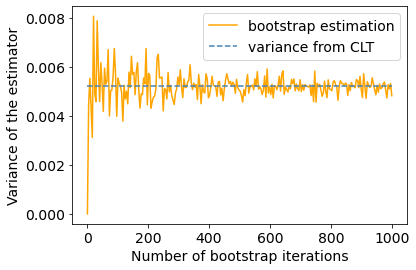

In [55]:
# Example: estimate the confidence interval for the mean of the head-turn delay on the ASD group 
# using bootstrap and the pivotal interval method. 
X = Xp ; n = len(X); bar_X = np.mean(X) 
# Recall our previous confidence interval estimation using the CLT. 
# Empirical variance (un-biased estimator using 1/n-1). 
var = lambda X: 1/(len(X)-1) * np.sum(np.array( [(X_i-np.mean(X))**2 for X_i in X] ))
se = np.sqrt(var(X)/n)  # Using CLT 

# Now using bootstrap
def bootstrap(X,B):
    bar_X_b = []
    for b in range(B):
        X_b = np.random.choice(X, n, replace=True)  # Get n samples from {X_1,...,X_n} with replacement. 
        bar_X_b.append(np.mean(X_b))  # Estimate the mean from the sample
    # Compute the mean of the estimated values
    v_boot = np.var(bar_X_b)
    return v_boot

fig = plt.figure()
Bs = np.linspace(1,1000,250); v_boots = [bootstrap(X,int(B)) for B in Bs];
plt.plot(Bs, v_boots, '-', color='orange'); 
plt.plot(Bs, [se**2 for B in Bs], '--', color='steelblue');
plt.legend(['bootstrap estimation', 'variance from CLT']); 
plt.xlabel('Number of bootstrap iterations'); plt.ylabel('Variance of the estimator');
glue("bootstrap_variance_estimation", fig, display=False)

```{glue:figure} bootstrap_variance_estimation
:figwidth: 80%
:name: "fig:bootstrap_variance_estimation"

Bootstrap variance estimation. 
```

In [205]:
# Compare 95% confidence intervals from bootstrap and from the CLT. 
alpha = 0.05
B = 200; bar_X_b = []
for b in range(B):
    X_b = np.random.choice(X, n, replace=True)  # Get n samples from {X_1,...,X_n} with replacement. 
    bar_X_b.append(np.mean(X_b))  # Estimate the mean from the sample

bar_X_u = np.quantile(bar_X_b, 1-alpha/2)
bar_X_l = np.quantile(bar_X_b, alpha/2)
hat_a = 2*bar_X - bar_X_u
hat_b = 2*bar_X - bar_X_l
print('Mean 95% conf interval from bootstrap :: ({:2.2f}, {:2.2f}) seconds'.format(hat_a, hat_b))
print('Mean 95% conf interval from CLT :: ({:2.2f}, {:2.2f}) seconds'.format(bar_X-2*se, bar_X+2*se))

Mean 95% conf interval from bootstrap :: (2.92, 3.20) seconds
Mean 95% conf interval from CLT :: (2.92, 3.18) seconds


(sec: pdf_estimation_with_missing_values)=
## PDF estimation with missing values

We compare different techniques to estimate the pdf using multidimensional kernel methods and when there is missing data in the fitting sample. 

![missing_data](../figs/pdf_missing_data.jpeg)

TODO: clean the equations presented in the figure and describe here. 

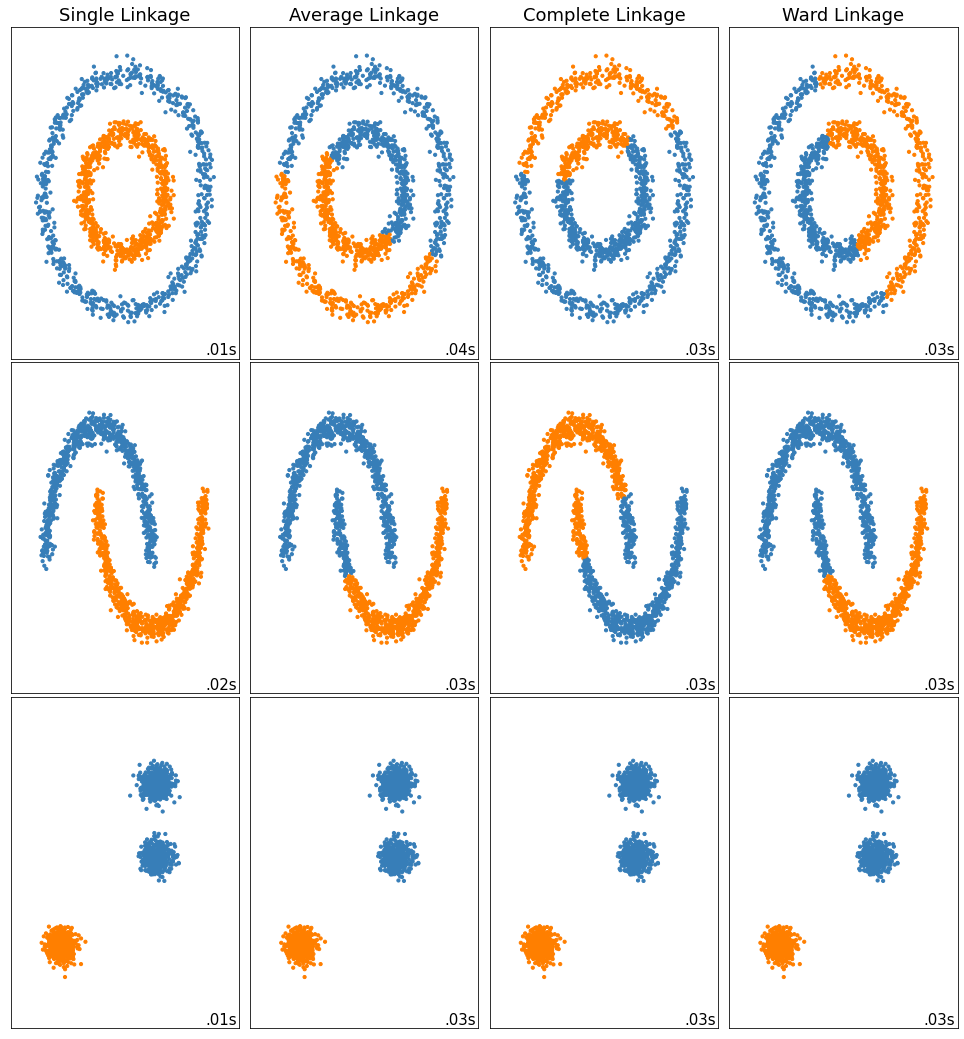

In [9]:
# Experiments: 
# 3 distribution shapes (one class)
# 3 inputation techniques (including our method)
# 3 levels of missing data (compare estimating using only the data for which all the coordinates are available)



# Source: 
# https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)


# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (blobs, {})]
   
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    # ============
    # Create cluster objects
    # ============
    ward = cluster.AgglomerativeClustering(
        n_clusters=2, linkage='ward')
    complete = cluster.AgglomerativeClustering(
        n_clusters=2, linkage='complete')
    average = cluster.AgglomerativeClustering(
        n_clusters=2, linkage='average')
    single = cluster.AgglomerativeClustering(
        n_clusters=2, linkage='single')
    
    clustering_algorithms = (
        ('Single Linkage', single),
        ('Average Linkage', average),
        ('Complete Linkage', complete),
        ('Ward Linkage', ward),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

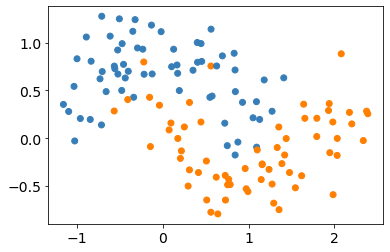

In [31]:
# Define the mask of missing data

# ==== set experiments parameters ==== #
missing_data_severity = .2 # 1 --> all missing data, 0 --> none missing data
n_samples = 200
# ==================================== #

from sklearn import cluster, datasets
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.25)
X,y = noisy_moons
M = np.random.random(X.shape) > missing_data_severity 
X_missing = X
X_missing[~M] = np.nan

colors = np.array(['#377eb8', '#ff7f00']) #,'#4daf4a'])
plt.scatter(X_missing[:,0], X_missing[:,1], c=colors[y])

In [32]:
XX = X_missing[y==0]
XX

xx

[array([[-2.        , -1.83333333, -1.66666667, -1.5       , -1.33333333,
         -1.16666667, -1.        , -0.83333333, -0.66666667, -0.5       ,
         -0.33333333, -0.16666667,  0.        ,  0.16666667,  0.33333333,
          0.5       ,  0.66666667,  0.83333333,  1.        ,  1.16666667,
          1.33333333,  1.5       ,  1.66666667,  1.83333333,  2.        ],
        [-2.        , -1.83333333, -1.66666667, -1.5       , -1.33333333,
         -1.16666667, -1.        , -0.83333333, -0.66666667, -0.5       ,
         -0.33333333, -0.16666667,  0.        ,  0.16666667,  0.33333333,
          0.5       ,  0.66666667,  0.83333333,  1.        ,  1.16666667,
          1.33333333,  1.5       ,  1.66666667,  1.83333333,  2.        ],
        [-2.        , -1.83333333, -1.66666667, -1.5       , -1.33333333,
         -1.16666667, -1.        , -0.83333333, -0.66666667, -0.5       ,
         -0.33333333, -0.16666667,  0.        ,  0.16666667,  0.33333333,
          0.5       ,  0.66666667,  

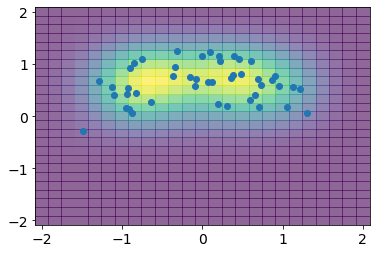

In [48]:
# ==== set experiments parameters ==== #
missing_data_severity = .5 # 1 --> all missing data, 0 --> none missing data
n_samples = 400
# ==================================== #

from sklearn import cluster, datasets
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.25)
X,y = noisy_moons
M = np.random.random(X.shape) > missing_data_severity 
X_missing = X
X_missing[~M] = np.nan
XX = X_missing[y==0]

colors = np.array(['#377eb8', '#ff7f00']) #,'#4daf4a'])
#plt.scatter(X_missing[:,0], X_missing[:,1], c=colors[y])

from stats import F
xx = np.meshgrid(np.linspace(-2,2,25),np.linspace(-2,2,25))
h = .3

H,W = xx[0].shape
hat_f = np.zeros_like(xx[0])
for i in range(H):
    for j in range(W):
        x = xx[0][i,j]
        y = xx[1][i,j]
        hat_f[i,j] = F(XX,[x,y],h=h)

plt.pcolormesh(xx[0], xx[1], hat_f, shading='auto', alpha=.6)
plt.scatter(XX[:,0],XX[:,1])

In [35]:
# Sanity check 
np.sum(hat_f)


0.15865293483887224

(200, 2)
(46, 2)


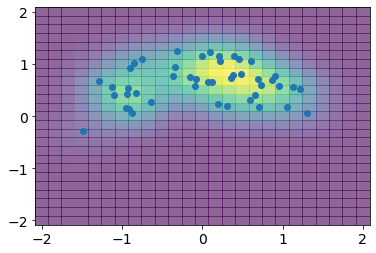

In [57]:
print(XX.shape)
XX2 = XX[~np.isnan(XX[:,0]),:]
XX2 = XX2[~np.isnan(XX2[:,1]),:]
print(XX2.shape)

H,W = xx[0].shape
hat_f = np.zeros_like(xx[0])
for i in range(H):
    for j in range(W):
        x = xx[0][i,j]
        y = xx[1][i,j]
        hat_f[i,j] = F(XX2,[x,y],h=h)

plt.pcolormesh(xx[0], xx[1], hat_f, shading='auto', alpha=.6)
plt.scatter(XX[:,0],XX[:,1])

